# MedGemma EVALUATION and PLOTS

Google, MedGemma 4B pt: https://huggingface.co/google/medgemma-4b-pt and https://github.com/Google-Health/medgemma

LLM Disclaimer: Debugging was done with the help of ChatGPT: https://chatgpt.com/

In [45]:
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig, pipeline
from PIL import Image
import requests
import torch
import pandas as pd
import os
import numpy as np
import logging
import pickle
from peft import LoraConfig
from trl import SFTConfig
from trl import SFTTrainer
from datasets import Dataset
import re
from collections import OrderedDict

import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, balanced_accuracy_score

# LOAD BD MINI DATA

In [1]:
#brazilian_dataset_mini = pd.read_csv("mini_brazilian_dataset.csv")

In [3]:
#with open('folds_with_validation_mini.pkl','rb') as f:
    #folds_mini_tvt = pickle.load(f)    

# BINARY CLASSIFICATION

## FINE-TUNING ON BD MINI

In [4]:
DR_01_CLASSES = ["0 - Normal", "1 - Diabetic Retinopathy"]

In [5]:
def get_format_data_01(processor):
    """
    to convert the label to an integer
    to map it to a class name
    to prepend a special token to the answer
    return a function that formats each dataset example for the model
    """
    def format_data_01(example):
        label = int(example['diabetic_retinopathy'])
        answer = DR_01_CLASSES[label]
        example['label'] = label
        boi_token = processor.tokenizer.special_tokens_map["boi_token"]
        example['answer'] = f"{boi_token}{answer}"
    
        return example
    return format_data_01

In [6]:
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=16,
    bias="none",
    target_modules="all-linear",
    task_type="CAUSAL_LM",
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

In [7]:
def collate_fn_01(processor):
    """
    to create a batch
    to tokenize them with the processor
    to create training labels that ignore (mask with -100) the prompt and padding tokens
    """
    def collate_fn(examples):
        texts = []
        images = []
        for example in examples:
            images.append(Image.open(example['full_path']).convert('RGB'))
            texts.append(example['answer'])
            
        batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

        labels = batch["input_ids"].clone()

        for i, example in enumerate(examples):
            prompt_ids = processor.tokenizer(example['answer'], add_special_tokens=False).input_ids 
            labels[i, :len(prompt_ids)] = -100

        labels[labels == processor.tokenizer.pad_token_id] = -100

        batch["labels"] = labels
        return batch
    return collate_fn

In [8]:
model_id = "google/medgemma-4b-pt"

def model_and_processor():
    """
    to load a pretrained image-text-to-text model and its processor
    to set it to use bfloat16
    to apply 4-bit quantization for memory efficiency
    to set the tokenizer to right padding
    """
    if torch.cuda.get_device_capability()[0] < 8:
        raise ValueError("GPU does not support bfloat16, please use a GPU that supports bfloat16.")
        
    model_kwargs = dict(
        attn_implementation="eager",
        torch_dtype=torch.bfloat16,
        device_map="auto",
    )
    model_kwargs["quantization_config"] = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=model_kwargs["torch_dtype"],
        bnb_4bit_quant_storage=model_kwargs["torch_dtype"],
    )
    model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)
    processor = AutoProcessor.from_pretrained(model_id)

    processor.tokenizer.padding_side = "right"
    return model, processor

In [9]:
#log = logging.getLogger(f"medgemma_ft_mini_BD_only_labels")
#log.setLevel(logging.INFO)
#if log.hasHandlers():
#    log.handlers.clear()
#filehandler = logging.FileHandler(f"medgemma_ft_mini_BD_only_labels.log", encoding='utf-8') 
#formatter= logging.Formatter('%(asctime)s %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')
#filehandler.setFormatter(formatter)
#log.addHandler(filehandler)
#for fold in range (10):
#    log.info(f"START FOLD {fold}")
#    
#    model, processor = model_and_processor()
#    
#    train_df = folds_mini_tvt[fold]['train'].reset_index(drop=True)
#    val_df = folds_mini_tvt[fold]['val'].reset_index(drop=True)
#
#    hf_train_df = Dataset.from_pandas(train_df).map(get_format_data_01(processor))
#    hf_val_df = Dataset.from_pandas(val_df).map(get_format_data_01(processor))
#    
#    
#    args = SFTConfig(
#    output_dir="medgemma-4b-pt-sft-lora-crc100k_last_BD_mini_just_labels",            # Directory and Hub repository id to save the model to
#    num_train_epochs=1,                                      # Number of training epochs
#    per_device_train_batch_size=1,                           # Batch size per device during training
#    per_device_eval_batch_size=1,                            # Batch size per device during evaluation
#    gradient_accumulation_steps=4,                           # Number of steps before performing a backward/update pass
#    gradient_checkpointing=True,                             # Enable gradient checkpointing to reduce memory usage
#    optim="adamw_torch_fused",                               # Use fused AdamW optimizer for better performance
#    logging_steps=50,                                        # Number of steps between logs
#    save_strategy="epoch",                                   # Save checkpoint every epoch
#    eval_strategy="steps",                                   # Evaluate every `eval_steps`
#    eval_steps=50,                                           # Number of steps between evaluations
#    learning_rate=2e-4,                                      # Learning rate based on QLoRA paper
#    bf16=True,                                               # Use bfloat16 precision
#    max_grad_norm=0.3,                                       # Max gradient norm based on QLoRA paper
#    warmup_ratio=0.03,                                       # Warmup ratio based on QLoRA paper
#    lr_scheduler_type="linear",                              # Use linear learning rate scheduler
#    push_to_hub=False,                                        # Push model to Hub
#    report_to="tensorboard",                                 # Report metrics to tensorboard
#    gradient_checkpointing_kwargs={"use_reentrant": False},  # Set gradient checkpointing to non-reentrant to avoid issues
#    dataset_kwargs={"skip_prepare_dataset": True},           # Skip default dataset preparation to preprocess manually
#    remove_unused_columns = False,                           # Columns are unused for training but needed for data collator
#    label_names=["labels"],                                  # Input keys that correspond to the labels
#    )
#    
#    trainer = SFTTrainer(
#    model=model,
#    args=args,
#    train_dataset=hf_train_df,
#    eval_dataset=hf_val_df.shuffle(),  # Use subset of validation set for faster run
#    peft_config=peft_config,
#    processing_class=processor,
#    data_collator=collate_fn_01(processor),
#    )
#    
#    log.info(f"START TRAIN FOLD {fold}")
#    trainer.train()
#    log.info(f"SAVE MODEL FOR FOLD {fold}")
#    trainer.save_model()
#    
#    log.info(f"CLEAN CACHE")
#    del model
#    del trainer
#    torch.cuda.empty_cache()
    
#    log.info(f"FOLD {fold} - DONE!!!")
    

## EVALUATION ON BD MINI

In [10]:
model, processor = model_and_processor()

`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.79s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [11]:
def postprocess(prediction):
    text = prediction[0]["generated_text"].lower().strip()

    tokens = re.findall(r"\b\w+\b", text)

    # ordered unique tokens (keeps first occurrence)
    tokens = list(OrderedDict.fromkeys(tokens))

    keyword_map = {
        0: ["normal", "healthy", "no"],
        1: ["retinopathy", "dr"],
    }

    for tok in tokens:
        if tok.isdigit() and tok in {"0", "1"}:
            return int(tok), text

        for cls, kws in keyword_map.items():
            if tok in kws:
                return cls, text

    if "0" in text or "normal" in text:
        return 0, text
    if "1" in text or "retinopathy" in text:
        return 1, text

    return -1, text

In [12]:
def add_noise(image_pil, noise_level, seed=42):
    if noise_level == "small":
        std = 0.02
    elif noise_level == "medium":
        std = 0.05
    elif noise_level == "large":
        std = 0.15
    else:
        std = 0.0

    if seed is not None:
        torch.manual_seed(seed)

    image = TF.to_tensor(image_pil)

    noise = torch.randn_like(image) * std
    image = image + noise

    image = torch.clamp(image, 0.0, 1.0)

    return TF.to_pil_image(image)

In [13]:
output_dir = "medgemma-4b-pt-sft-lora-crc100k_last_BD_mini_just_labels"

noise_levels = ["no", "small", "medium", "large"]

predictions_noise = {n: [] for n in noise_levels}

for noise_level in noise_levels:

    for fold in range(10):

        test_df = folds_mini_tvt[fold]["test"].reset_index(drop=True)
        references = test_df["diabetic_retinopathy"].tolist()
        hf_test_df = Dataset.from_pandas(test_df).map(get_format_data_01(processor))

        ft_pipe = pipeline(
            "image-text-to-text",
            model=output_dir,
            processor=processor,
            torch_dtype=torch.bfloat16,
            device_map="auto",
        )

        ft_pipe.model.generation_config.do_sample = False
        ft_pipe.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id
        processor.tokenizer.padding_side = "left"

        fold_predictions = []

        for idx, (answer, img_path, label) in enumerate(
            zip(hf_test_df["answer"], hf_test_df["full_path"], references)
        ):
            img = Image.open(img_path).convert("RGB")

            if noise_level != "no":
                img = add_noise(img, noise_level)

            output = ft_pipe(
                text=[answer],
                images=[img],
                max_new_tokens=20,
                return_full_text=False,
            )

            pred, gen_text = postprocess(output)

            fold_predictions.append(
                {
                    "noise": noise_level,
                    "fold": fold,
                    "index": idx,
                    "label": label,
                    "prediction": pred,
                    "generated_text": gen_text,
                    "image_path": img_path,
                }
            )

        preds = [x["prediction"] for x in fold_predictions]

        predictions_noise[noise_level].extend(fold_predictions)


Map: 100%|██████████| 229/229 [00:00<00:00, 9340.98 examples/s]
`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.18s/it]
/gpfs01/berens/user/aschaefer/miniconda3/envs/medgemma_env/lib/python3.11/site-packages/peft/tuners/tuners_utils.py:1222: UserWarning: Model has `tie_word_embeddings=True` and a tied layer is part of the adapter, but `ensure_weight_tying` is not set to True. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. Check the discussion here: https://github.com/huggingface/peft/issues/2777
  warnings.warn(msg)
Device set to use cuda:0
`generation_config` default values have been modified to match model-specific defaults: {'pad_token_id': 1}. If this is not desired, please set these values explicitly.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Loading checkpoint shards:

In [14]:
BD_mini_MG_output_01_noise_no_just_labels = pd.DataFrame(predictions_noise["no"])
BD_mini_MG_output_01_noise_small_just_labels  = pd.DataFrame(predictions_noise["small"])
BD_mini_MG_output_01_noise_medium_just_labels  = pd.DataFrame(predictions_noise["medium"])
BD_mini_MG_output_01_noise_large_just_labels  = pd.DataFrame(predictions_noise["large"])

In [15]:
BD_mini_MG_output_01_noise_no_just_labels.to_csv("BD_mini_MG_output_01_noise_no_just_labels.csv", index=False)
BD_mini_MG_output_01_noise_small_just_labels.to_csv("BD_mini_MG_output_01_noise_small_just_labels.csv", index=False)
BD_mini_MG_output_01_noise_medium_just_labels.to_csv("BD_mini_MG_output_01_noise_medium_just_labels.csv", index=False)
BD_mini_MG_output_01_noise_large_just_labels.to_csv("BD_mini_MG_output_01_noise_large_just_labels.csv", index=False)

### ft on MedGemma EVALUATION on BD mini

In [ ]:
output_dir = "medgemma-4b-pt-sft-lora-crc100k_messidor_01_just_labels"

noise_levels = ["no", "small", "medium", "large"]

predictions_noise = {n: [] for n in noise_levels}

for noise_level in noise_levels:

    for fold in range(10):

        test_df = folds_mini_tvt[fold]["test"].reset_index(drop=True)
        references = test_df["diabetic_retinopathy"].tolist()
        hf_test_df = Dataset.from_pandas(test_df).map(get_format_data_01(processor))

        ft_pipe = pipeline(
            "image-text-to-text",
            model=output_dir,
            processor=processor,
            torch_dtype=torch.bfloat16,
            device_map="auto",
        )

        ft_pipe.model.generation_config.do_sample = False
        ft_pipe.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id
        processor.tokenizer.padding_side = "left"

        fold_predictions = []

        for idx, (answer, img_path, label) in enumerate(
            zip(hf_test_df["answer"], hf_test_df["full_path"], references)
        ):
            img = Image.open(img_path).convert("RGB")

            if noise_level != "no":
                img = add_noise(img, noise_level)

            output = ft_pipe(
                text=[answer],
                images=[img],
                max_new_tokens=20,
                return_full_text=False,
            )

            pred, gen_text = postprocess(output)

            fold_predictions.append(
                {
                    "noise": noise_level,
                    "fold": fold,
                    "index": idx,
                    "label": label,
                    "prediction": pred,
                    "generated_text": gen_text,
                    "image_path": img_path,
                }
            )

        preds = [x["prediction"] for x in fold_predictions]

        predictions_noise[noise_level].extend(fold_predictions)

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.34s/it]
Device set to use cuda:0
Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.32s/it]
Device set to use cuda:0
Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.33s/it]
Device set to use cuda:0
Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.32s/it]
Device set to use cuda:0


In [ ]:
MES_MG_output_01_noise_no_just_labels = pd.DataFrame(predictions_noise["no"])
MES_MG_output_01_noise_small_just_labels = pd.DataFrame(predictions_noise["small"])
MES_MG_output_01_noise_medium_just_labels = pd.DataFrame(predictions_noise["medium"])
MES_MG_output_01_noise_large_just_labels = pd.DataFrame(predictions_noise["large"])

In [ ]:
MES_MG_output_01_noise_no_just_labels.to_csv("MES_MG_output_01_noise_no_just_labels.csv", index=False)
MES_MG_output_01_noise_small_just_labels.to_csv("MES_MG_output_01_noise_small_just_labels.csv", index=False)
MES_MG_output_01_noise_medium_just_labels.to_csv("MES_MG_output_01_noise_medium_just_labels.csv", index=False)
MES_MG_output_01_noise_large_just_labels.to_csv("MES_MG_output_01_noise_large_just_labels.csv", index=False)

## FINE-TUNING ON MESSIDOR

In [4]:
#with open('folds_messidor_with_validation.pkl','rb') as f:
    #folds_mini_tvt_messidor = pickle.load(f)

In [ ]:
def get_format_data_01(processor):
    def format_data_01(example):
        label_float = example["adjudicated_dr_grade"]
        label = 0 if label_float == 0 else 1
        answer = DR_01_CLASSES[label]
        example['label'] = label
        boi_token = processor.tokenizer.special_tokens_map["boi_token"]
        example['answer'] = f"{boi_token}{answer}"
    
        return example
    return format_data_01

In [ ]:
def collate_fn_01(processor):
    def collate_fn(examples):
        texts = []
        images = []
        for example in examples:
            images.append(Image.open(example['full_path']).convert('RGB'))
            texts.append(example['answer'])
            
        # Tokenize the texts and process the images
        batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

        # The labels are the input_ids, with the padding and image tokens masked in
        # the loss computation
        labels = batch["input_ids"].clone()

        for i, example in enumerate(examples):
            prompt_ids = processor.tokenizer(example['answer'], add_special_tokens=False).input_ids 
            labels[i, :len(prompt_ids)] = -100

        labels[labels == processor.tokenizer.pad_token_id] = -100

        batch["labels"] = labels
        return batch
    return collate_fn

In [ ]:
#log = logging.getLogger(f"medgemma_ft_messidor_just_labels")
#log.setLevel(logging.INFO)
#if log.hasHandlers():
#    log.handlers.clear()
#filehandler = logging.FileHandler(f"medgemma_ft_messidor_just_labels.log", encoding='utf-8') 
#formatter= logging.Formatter('%(asctime)s %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')
#filehandler.setFormatter(formatter)
#log.addHandler(filehandler)
#for fold in range (10):
#    log.info(f"START FOLD {fold}")
#    
#    model, processor = model_and_processor()
    
#    train_df = folds_mini_tvt_messidor[fold]['train'].reset_index(drop=True)
#    val_df = folds_mini_tvt_messidor[fold]['val'].reset_index(drop=True)

#    hf_train_df = Dataset.from_pandas(train_df).map(get_format_data_01(processor))
#    hf_val_df = Dataset.from_pandas(val_df).map(get_format_data_01(processor))
    
#    args = SFTConfig(
#    output_dir="medgemma-4b-pt-sft-lora-crc100k_messidor_01_just_labels",            # Directory and Hub repository id to save the model to
#    num_train_epochs=1,                                      # Number of training epochs
#    per_device_train_batch_size=1,                           # Batch size per device during training
#    per_device_eval_batch_size=1,                            # Batch size per device during evaluation
#    gradient_accumulation_steps=4,                           # Number of steps before performing a backward/update pass
#    gradient_checkpointing=True,                             # Enable gradient checkpointing to reduce memory usage
#    optim="adamw_torch_fused",                               # Use fused AdamW optimizer for better performance
#    logging_steps=50,                                        # Number of steps between logs
#    save_strategy="epoch",                                   # Save checkpoint every epoch
#    eval_strategy="steps",                                   # Evaluate every `eval_steps`
#    eval_steps=50,                                           # Number of steps between evaluations
#    learning_rate=2e-4,                                      # Learning rate based on QLoRA paper
#    bf16=True,                                               # Use bfloat16 precision
#    max_grad_norm=0.3,                                       # Max gradient norm based on QLoRA paper
#    warmup_ratio=0.03,                                       # Warmup ratio based on QLoRA paper
#    lr_scheduler_type="linear",                              # Use linear learning rate scheduler
#    push_to_hub=False,                                        # Push model to Hub
#    report_to="tensorboard",                                 # Report metrics to tensorboard
#    gradient_checkpointing_kwargs={"use_reentrant": False},  # Set gradient checkpointing to non-reentrant to avoid issues
#    dataset_kwargs={"skip_prepare_dataset": True},           # Skip default dataset preparation to preprocess manually
#    remove_unused_columns = False,                           # Columns are unused for training but needed for data collator
#    label_names=["labels"],                                  # Input keys that correspond to the labels
#    )
    
#    trainer = SFTTrainer(
#    model=model,
#    args=args,
#    train_dataset=hf_train_df,
#    eval_dataset=hf_val_df.shuffle(),  # Use subset of validation set for faster run
#    peft_config=peft_config,
#    processing_class=processor,
#    data_collator=collate_fn_01(processor),
#    )
    
#    log.info(f"START TRAIN FOLD {fold}")
#    trainer.train()
#    log.info(f"SAVE MODEL FOR FOLD {fold}")
#    trainer.save_model()
    
#    log.info(f"CLEAN CACHE")
#    del model
#    del trainer
#    torch.cuda.empty_cache()
    
#    log.info(f"FOLD {fold} - DONE!!!")
    

# MULTICLASS

## FINE-TUNING ON BD MINI

In [ ]:
DR_04_CLASSES = ["0 - Normal", "1 - Mild non-proliferative diabetic retinopathy (NPDR)", "2 - Moderate NPDR", "3 - Severe NPDR", "4 - Proliferative DR"] 

In [ ]:
#def get_format_data_04(processor):
#    def format_data_04(example):
#        #image = Image.open(example['full_path']).convert('RGB')
#        label = int(example['DR_ICDR'])
#        #label = "Normal" if label_int == 0 else "Diabetic Retinopathy (DR)"
#        answer = DR_04_CLASSES[label]
#        #example['image'] = image
#        example['label'] = label
#        boi_token = processor.tokenizer.special_tokens_map["boi_token"]
#        example['prompt'] = f"{boi_token}{PROMPT_04}\nAnswer:"
#        example['answer'] = answer
#    
#        return example
#    return format_data_04


In [ ]:
def get_format_data_04(processor):
    def format_data_04(example):
        label = int(example['DR_ICDR'])
        answer = DR_04_CLASSES[label]
        example['label'] = label
        boi_token = processor.tokenizer.special_tokens_map["boi_token"]
        example['answer'] = f"{boi_token}{answer}"
    
        return example
    return format_data_04

In [ ]:
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=16,
    bias="none",
    target_modules="all-linear",
    task_type="CAUSAL_LM",
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

In [ ]:
def collate_fn_04(processor):
    def collate_fn(examples):
        texts = []
        images = []
        for example in examples:
            images.append(Image.open(example['full_path']).convert('RGB'))
            texts.append(example['answer'])
            
        # Tokenize the texts and process the images
        batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

        # The labels are the input_ids, with the padding and image tokens masked in
        # the loss computation
        labels = batch["input_ids"].clone()

        for i, example in enumerate(examples):
            prompt_ids = processor.tokenizer(example['answer'], add_special_tokens=False).input_ids 
            labels[i, :len(prompt_ids)] = -100

        labels[labels == processor.tokenizer.pad_token_id] = -100

        batch["labels"] = labels
        return batch
    return collate_fn

In [ ]:
model_id = "google/medgemma-4b-pt"

def model_and_processor():
    # Check if GPU supports bfloat16
    if torch.cuda.get_device_capability()[0] < 8:
        raise ValueError("GPU does not support bfloat16, please use a GPU that supports bfloat16.")
        
    model_kwargs = dict(
        attn_implementation="eager",
        torch_dtype=torch.bfloat16,
        device_map="auto",
    )
    model_kwargs["quantization_config"] = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=model_kwargs["torch_dtype"],
        bnb_4bit_quant_storage=model_kwargs["torch_dtype"],
    )
    model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)
    processor = AutoProcessor.from_pretrained(model_id)
    # Use right padding to avoid issues during training
    processor.tokenizer.padding_side = "right"
    return model, processor

In [ ]:
#log = logging.getLogger(f"medgemma_04_ft_mini_BD_just_labels")
#log.setLevel(logging.INFO)
#if log.hasHandlers():
#    log.handlers.clear()
#filehandler = logging.FileHandler(f"medgemma_04_ft_mini_BD_just_labels.log", encoding='utf-8') 
#formatter= logging.Formatter('%(asctime)s %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')
#filehandler.setFormatter(formatter)
#log.addHandler(filehandler)
#for fold in range (10):
#    log.info(f"START FOLD {fold}")
    
#    model, processor = model_and_processor()
    
#    train_df = folds_mini_tvt[fold]['train'].reset_index(drop=True)
#    val_df = folds_mini_tvt[fold]['val'].reset_index(drop=True)

#    hf_train_df = Dataset.from_pandas(train_df).map(get_format_data_04(processor))
#    hf_val_df = Dataset.from_pandas(val_df).map(get_format_data_04(processor))
    
    
#    args = SFTConfig(
#    output_dir="medgemma-4b-pt-sft-lora-crc100k_BD_mini_04_just_labels",            # Directory and Hub repository id to save the model to
#    num_train_epochs=1,                                      # Number of training epochs
#    per_device_train_batch_size=1,                           # Batch size per device during training
#    per_device_eval_batch_size=1,                            # Batch size per device during evaluation
#    gradient_accumulation_steps=4,                           # Number of steps before performing a backward/update pass
#    gradient_checkpointing=True,                             # Enable gradient checkpointing to reduce memory usage
#    optim="adamw_torch_fused",                               # Use fused AdamW optimizer for better performance
#    logging_steps=50,                                        # Number of steps between logs
#    save_strategy="epoch",                                   # Save checkpoint every epoch
#    eval_strategy="steps",                                   # Evaluate every `eval_steps`
#    eval_steps=50,                                           # Number of steps between evaluations
#    learning_rate=2e-4,                                      # Learning rate based on QLoRA paper
#    bf16=True,                                               # Use bfloat16 precision
#    max_grad_norm=0.3,                                       # Max gradient norm based on QLoRA paper
#    warmup_ratio=0.03,                                       # Warmup ratio based on QLoRA paper
#    lr_scheduler_type="linear",                              # Use linear learning rate scheduler
#    push_to_hub=False,                                        # Push model to Hub
#    report_to="tensorboard",                                 # Report metrics to tensorboard
#    gradient_checkpointing_kwargs={"use_reentrant": False},  # Set gradient checkpointing to non-reentrant to avoid issues
#    dataset_kwargs={"skip_prepare_dataset": True},           # Skip default dataset preparation to preprocess manually
#    remove_unused_columns = False,                           # Columns are unused for training but needed for data collator
#    label_names=["labels"],                                  # Input keys that correspond to the labels
#    )
    
#    trainer = SFTTrainer(
#    model=model,
#    args=args,
#    train_dataset=hf_train_df,
#    eval_dataset=hf_val_df.shuffle(),  # Use subset of validation set for faster run
#    peft_config=peft_config,
#    processing_class=processor,
#    data_collator=collate_fn_04(processor),
#    )
    
#    log.info(f"START TRAIN FOLD {fold}")
#    trainer.train()
#    log.info(f"SAVE MODEL FOR FOLD {fold}")
#    trainer.save_model()
    
#    log.info(f"CLEAN CACHE")
#    del model
#    del trainer
#    torch.cuda.empty_cache()
    
#    log.info(f"FOLD {fold} - DONE!!!")
    

## EVALUATION ON BD MINI

In [ ]:
def postprocess_multiclass(prediction):
    text = prediction[0]["generated_text"].lower().strip()

    tokens = re.findall(r"\b\w+\b", text)

    tokens = list(OrderedDict.fromkeys(tokens))

    keyword_map = {
        4: ["proliferative", "pdr"],
        3: ["severe"],
        2: ["moderate"],
        1: ["mild"],
        0: ["normal", "healthy", "no"],
    }

    for tok in tokens:
        if tok.isdigit():
            cls = int(tok)
            if 0 <= cls <= 4:
                return cls, text

        for cls, keywords in keyword_map.items():
            if tok in keywords:
                return cls, text

    for cls, keywords in keyword_map.items():
        for kw in keywords:
            if kw in text:
                return cls, text

    return -1, text

In [ ]:
output_dir = "medgemma-4b-pt-sft-lora-crc100k_BD_mini_04_just_labels"

noise_levels = ["no", "small", "medium", "large"]

predictions_noise = {n: [] for n in noise_levels}

for noise_level in noise_levels:

    for fold in range(10):

        test_df = folds_mini_tvt[fold]["test"].reset_index(drop=True)
        references = test_df["diabetic_retinopathy"].tolist()
        hf_test_df = Dataset.from_pandas(test_df).map(get_format_data_04(processor))

        ft_pipe = pipeline(
            "image-text-to-text",
            model=output_dir,
            processor=processor,
            torch_dtype=torch.bfloat16,
            device_map="auto",
        )

        ft_pipe.model.generation_config.do_sample = False
        ft_pipe.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id
        processor.tokenizer.padding_side = "left"

        fold_predictions = []

        for idx, (answer, img_path, label) in enumerate(
            zip(hf_test_df["answer"], hf_test_df["full_path"], references)
        ):
            img = Image.open(img_path).convert("RGB")

            if noise_level != "no":
                img = add_noise(img, noise_level)

            output = ft_pipe(
                text=[answer],
                images=[img],
                max_new_tokens=20,
                return_full_text=False,
            )

            pred, gen_text = postprocess_multiclass(output)

            fold_predictions.append(
                {
                    "noise": noise_level,
                    "fold": fold,
                    "index": idx,
                    "label": label,
                    "prediction": pred,
                    "generated_text": gen_text,
                    "image_path": img_path,
                }
            )

        preds = [x["prediction"] for x in fold_predictions]

        predictions_noise[noise_level].extend(fold_predictions)

In [ ]:
BD_mini_MG_output_04_noise_no_just_labels = pd.DataFrame(predictions_noise["no"])
BD_mini_MG_output_04_noise_small_just_labels = pd.DataFrame(predictions_noise["small"])
BD_mini_MG_output_04_noise_medium_just_labels = pd.DataFrame(predictions_noise["medium"])
BD_mini_MG_output_04_noise_large_just_labels = pd.DataFrame(predictions_noise["large"])

In [ ]:
BD_mini_MG_output_04_noise_no_just_labels.to_csv("BD_mini_MG_output_04_noise_no_just_labels.csv", index=False)
BD_mini_MG_output_04_noise_small_just_labels.to_csv("BD_mini_MG_output_04_noise_small_just_labels.csv", index=False)
BD_mini_MG_output_04_noise_medium_just_labels.to_csv("BD_mini_MG_output_04_noise_medium_just_labels.csv", index=False)
BD_mini_MG_output_04_noise_large_just_labels.to_csv("BD_mini_MG_output_04_noise_large_just_labels.csv", index=False)

In [ ]:
output_dir = "medgemma-4b-pt-sft-lora-crc100k_messidor_04_just_labels"

noise_levels = ["no", "small", "medium", "large"]

predictions_noise = {n: [] for n in noise_levels}

for noise_level in noise_levels:

    for fold in range(10):

        test_df = folds_mini_tvt[fold]["test"].reset_index(drop=True)
        references = test_df["diabetic_retinopathy"].tolist()
        hf_test_df = Dataset.from_pandas(test_df).map(get_format_data_04(processor))

        ft_pipe = pipeline(
            "image-text-to-text",
            model=output_dir,
            processor=processor,
            torch_dtype=torch.bfloat16,
            device_map="auto",
        )

        ft_pipe.model.generation_config.do_sample = False
        ft_pipe.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id
        processor.tokenizer.padding_side = "left"

        fold_predictions = []

        for idx, (answer, img_path, label) in enumerate(
            zip(hf_test_df["answer"], hf_test_df["full_path"], references)
        ):
            img = Image.open(img_path).convert("RGB")

            if noise_level != "no":
                img = add_noise(img, noise_level)

            output = ft_pipe(
                text=[answer],
                images=[img],
                max_new_tokens=20,
                return_full_text=False,
            )

            pred, gen_text = postprocess_multiclass(output)

            fold_predictions.append(
                {
                    "noise": noise_level,
                    "fold": fold,
                    "index": idx,
                    "label": label,
                    "prediction": pred,
                    "generated_text": gen_text,
                    "image_path": img_path,
                }
            )

        preds = [x["prediction"] for x in fold_predictions]

        predictions_noise[noise_level].extend(fold_predictions)

In [ ]:
MES_MG_output_04_noise_no_just_labels = pd.DataFrame(predictions_noise["no"])
MES_MG_output_04_noise_small_just_labels = pd.DataFrame(predictions_noise["small"])
MES_MG_output_04_noise_medium_just_labels = pd.DataFrame(predictions_noise["medium"])
MES_MG_output_04_noise_large_just_labels = pd.DataFrame(predictions_noise["large"])

In [ ]:
MES_MG_output_04_noise_no_just_labels.to_csv("MES_MG_output_04_noise_no_just_labels.csv", index=False)
MES_MG_output_04_noise_small_just_labels.to_csv("MES_MG_output_04_noise_small_just_labels.csv", index=False)
MES_MG_output_04_noise_medium_just_labels.to_csv("MES_MG_output_04_noise_medium_just_labels.csv", index=False)
MES_MG_output_04_noise_large_just_labels.to_csv("MES_MG_output_04_noise_large_just_labels.csv", index=False)

## FINE-TUNING ON MESSIDOR

In [ ]:
def get_format_data_04(processor):
    def format_data_04(example):
        label = int(example["adjudicated_dr_grade"])
        answer = DR_04_CLASSES[label]
        example['label'] = label
        boi_token = processor.tokenizer.special_tokens_map["boi_token"]
        example['answer'] = f"{boi_token}{answer}"
    
        return example
    return format_data_04

In [ ]:
def collate_fn_04(processor):
    def collate_fn(examples):
        texts = []
        images = []
        for example in examples:
            images.append(Image.open(example['full_path']).convert('RGB'))
            texts.append(example['answer'])
            
        # Tokenize the texts and process the images
        batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

        # The labels are the input_ids, with the padding and image tokens masked in
        # the loss computation
        labels = batch["input_ids"].clone()

        for i, example in enumerate(examples):
            prompt_ids = processor.tokenizer(example['answer'], add_special_tokens=False).input_ids 
            labels[i, :len(prompt_ids)] = -100

        labels[labels == processor.tokenizer.pad_token_id] = -100

        batch["labels"] = labels
        return batch
    return collate_fn

In [ ]:
#log = logging.getLogger(f"medgemma_04_ft_messidor_just_labels")
#log.setLevel(logging.INFO)
#if log.hasHandlers():
#    log.handlers.clear()
#filehandler = logging.FileHandler(f"medgemma_04_ft_messidor_just_labels.log", encoding='utf-8') 
#formatter= logging.Formatter('%(asctime)s %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')
#filehandler.setFormatter(formatter)
#log.addHandler(filehandler)
#for fold in range (10):
#    log.info(f"START FOLD {fold}")
    
#    model, processor = model_and_processor()
    
#    train_df = folds_mini_tvt_messidor[fold]['train'].reset_index(drop=True)
#    val_df = folds_mini_tvt_messidor[fold]['val'].reset_index(drop=True)

#    hf_train_df = Dataset.from_pandas(train_df).map(get_format_data_04(processor))
#    hf_val_df = Dataset.from_pandas(val_df).map(get_format_data_04(processor))
    
#    args = SFTConfig(
#    output_dir="medgemma-4b-pt-sft-lora-crc100k_messidor_04_just_labels",            # Directory and Hub repository id to save the model to
#    num_train_epochs=1,                                      # Number of training epochs
#    per_device_train_batch_size=1,                           # Batch size per device during training
#    per_device_eval_batch_size=1,                            # Batch size per device during evaluation
#    gradient_accumulation_steps=4,                           # Number of steps before performing a backward/update pass
#    gradient_checkpointing=True,                             # Enable gradient checkpointing to reduce memory usage
#    optim="adamw_torch_fused",                               # Use fused AdamW optimizer for better performance
#    logging_steps=50,                                        # Number of steps between logs
#    save_strategy="epoch",                                   # Save checkpoint every epoch
#    eval_strategy="steps",                                   # Evaluate every `eval_steps`
#    eval_steps=50,                                           # Number of steps between evaluations
#    learning_rate=2e-4,                                      # Learning rate based on QLoRA paper
#    bf16=True,                                               # Use bfloat16 precision
#    max_grad_norm=0.3,                                       # Max gradient norm based on QLoRA paper
#    warmup_ratio=0.03,                                       # Warmup ratio based on QLoRA paper
#    lr_scheduler_type="linear",                              # Use linear learning rate scheduler
#    push_to_hub=False,                                        # Push model to Hub
#    report_to="tensorboard",                                 # Report metrics to tensorboard
#    gradient_checkpointing_kwargs={"use_reentrant": False},  # Set gradient checkpointing to non-reentrant to avoid issues
#    dataset_kwargs={"skip_prepare_dataset": True},           # Skip default dataset preparation to preprocess manually
#    remove_unused_columns = False,                           # Columns are unused for training but needed for data collator
#    label_names=["labels"],                                  # Input keys that correspond to the labels
#    )
    
#    trainer = SFTTrainer(
#    model=model,
#    args=args,
#    train_dataset=hf_train_df,
#    eval_dataset=hf_val_df.shuffle(),  # Use subset of validation set for faster run
#    peft_config=peft_config,
#    processing_class=processor,
#    data_collator=collate_fn_04(processor),
#    )
    
#    log.info(f"START TRAIN FOLD {fold}")
#    trainer.train()
#    log.info(f"SAVE MODEL FOR FOLD {fold}")
#    trainer.save_model()
    
#    log.info(f"CLEAN CACHE")
#    del model
#    del trainer
#    torch.cuda.empty_cache()
    
#    log.info(f"FOLD {fold} - DONE!!!")
    

# PLOTS

## FUNCTIONS

In [40]:
def get_metrics(df, fold_col='fold', label_col='label', pred_col='prediction', binary=True, average='macro'):
    metrics_list = []
    folds = sorted(df[fold_col].unique())

    for f in folds:
        fold_df = df[df[fold_col] == f]
        y_gt = fold_df[label_col].values
        y_pred = fold_df[pred_col].values

        fold_metrics = {
            'fold': f,
            'accuracy': accuracy_score(y_gt, y_pred),
            'f1': f1_score(y_gt, y_pred, average='binary' if binary else average, zero_division=0),
            'precision': precision_score(y_gt, y_pred, average='binary' if binary else average, zero_division=0),
            'recall': recall_score(y_gt, y_pred, average='binary' if binary else average, zero_division=0),
            'acc_bal': balanced_accuracy_score(y_gt, y_pred)
        }

        if binary:
            # Compute specificity for binary only
            try:
                tn, fp, fn, tp = confusion_matrix(y_gt, y_pred).ravel()
                fold_metrics['specificity'] = tn / (tn + fp)
            except ValueError:
                fold_metrics['specificity'] = np.nan

        metrics_list.append(fold_metrics)

    return pd.DataFrame(metrics_list)

In [41]:
def plot_biclass(metrics):
    """
    plot metrics for binary classification
    """
    mets = ['accuracy','f1', 'precision', 'recall', 'specificity', 'acc_bal']
    
    n_mets = len(mets)
    n_cols = 3 
    n_rows = int(np.ceil(n_mets / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows), sharey=True)
    axes = axes.flatten()
    
    for ax, m in zip(axes, mets):
        sns.barplot(x='fold', y=m, data=metrics, ax=ax, color='skyblue', errorbar=None)
        
        mean_val = metrics[m].mean()
        std_val = metrics[m].std()
        

        ax.axhline(mean_val, color='red', linestyle='--', label=f"Mean = {mean_val:.2f}")
        ax.fill_between(
            x=range(len(metrics)),
            y1=mean_val - std_val,
            y2=mean_val + std_val,
            color='red',
            alpha=0.2,
            label="±1 SD"
        )

        for i, val in enumerate(metrics[m]):
            ax.text(i, val/2, f"{val:.2f}", ha='center', va='center', fontsize=10, color='black')
        
        ax.set_xticks(range(len(metrics['fold'])))
        ax.set_xticklabels(metrics['fold'], rotation=45, ha='right')
        ax.set_title(m, fontsize=14)
        ax.set_xlabel("Fold", fontsize=12)
        ax.set_ylabel("Score", fontsize=12)
        ax.set_ylim(0, 1)
        ax.legend(loc='lower right', fontsize=10)
    
    for j in range(len(mets), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [42]:
def plot_multiclass(metrics):
    """
    plot metrics for multi classification
    """
    mets = ['accuracy','f1','precision','recall','acc_bal']
    
    n_mets = len(mets)
    n_cols = 3 
    n_rows = int(np.ceil(n_mets / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows), sharey=True)
    axes = axes.flatten() 
    
    for ax, m in zip(axes, mets):
        sns.barplot(x='fold', y=m, data=metrics, ax=ax, color='skyblue', errorbar=None)
        
        mean_val = metrics[m].mean()
        std_val = metrics[m].std()
        
        ax.axhline(mean_val, color='red', linestyle='--', label=f"Mean = {mean_val:.2f}")
        ax.fill_between(
            x=range(len(metrics)),
            y1=mean_val - std_val,
            y2=mean_val + std_val,
            color='red',
            alpha=0.2,
            label="±1 SD"
        )
        
        for i, val in enumerate(metrics[m]):
            ax.text(i, val/2, f"{val:.2f}", ha='center', va='center', fontsize=10, color='black')
        
        ax.set_xticks(range(len(metrics['fold'])))
        ax.set_xticklabels(metrics['fold'], rotation=45, ha='right')
        ax.set_title(m, fontsize=14)
        ax.set_xlabel("Fold", fontsize=12)
        ax.set_ylabel("Score", fontsize=12)
        ax.set_ylim(0, 1)
        ax.legend(loc='lower right', fontsize=10)
    
    for j in range(len(mets), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

## DATA

In [46]:
no_noise_01_BD_mini = pd.read_csv("BD_mini_MG_output_01_noise_no_just_labels.csv")
small_noise_01_BD_mini = pd.read_csv("BD_mini_MG_output_01_noise_small_just_labels.csv")
medium_noise_01_BD_mini = pd.read_csv("BD_mini_MG_output_01_noise_medium_just_labels.csv")
large_noise_01_BD_mini = pd.read_csv("BD_mini_MG_output_01_noise_large_just_labels.csv")

no_noise_04_BD_mini = pd.read_csv("BD_mini_MG_output_04_noise_no_just_labels.csv")
small_noise_04_BD_mini = pd.read_csv("BD_mini_MG_output_04_noise_small_just_labels.csv")
medium_noise_04_BD_mini = pd.read_csv("BD_mini_MG_output_04_noise_medium_just_labels.csv")
large_noise_04_BD_mini = pd.read_csv("BD_mini_MG_output_04_noise_large_just_labels.csv")

no_noise_01_MES = pd.read_csv("MES_MG_output_01_noise_no_just_labels.csv")
small_noise_01_MES = pd.read_csv("MES_MG_output_01_noise_small_just_labels.csv")
medium_noise_01_MES = pd.read_csv("MES_MG_output_01_noise_medium_just_labels.csv")
large_noise_01_MES = pd.read_csv("MES_MG_output_01_noise_large_just_labels.csv")

no_noise_04_MES = pd.read_csv("MES_MG_output_04_noise_no_just_labels.csv")
small_noise_04_MES = pd.read_csv("MES_MG_output_04_noise_small_just_labels.csv")
medium_noise_04_MES = pd.read_csv("MES_MG_output_04_noise_medium_just_labels.csv")
large_noise_04_MES = pd.read_csv("MES_MG_output_04_noise_large_just_labels.csv")

In [47]:
metrics_no_noise_01_BD_mini = get_metrics(no_noise_01_BD_mini, binary=True)
metrics_small_noise_01_BD_mini = get_metrics(small_noise_01_BD_mini, binary=True)
metrics_medium_noise_01_BD_mini = get_metrics(medium_noise_01_BD_mini, binary=True)
metrics_large_noise_01_BD_mini = get_metrics(large_noise_01_BD_mini, binary=True)

metrics_no_noise_04_BD_mini = get_metrics(no_noise_04_BD_mini, binary=False)
metrics_small_noise_04_BD_mini = get_metrics(small_noise_04_BD_mini, binary=False)
metrics_medium_noise_04_BD_mini = get_metrics(medium_noise_04_BD_mini, binary=False)
metrics_large_noise_04_BD_mini = get_metrics(large_noise_04_BD_mini, binary=False)

metrics_no_noise_01_MES = get_metrics(no_noise_01_MES, binary=True)
metrics_small_noise_01_MES = get_metrics(small_noise_01_MES, binary=True)
metrics_medium_noise_01_MES = get_metrics(medium_noise_01_MES, binary=True)
metrics_large_noise_01_MES = get_metrics(large_noise_01_MES, binary=True)

metrics_no_noise_04_MES = get_metrics(no_noise_04_MES, binary=False)
metrics_small_noise_04_MES = get_metrics(small_noise_04_MES, binary=False)
metrics_medium_noise_04_MES = get_metrics(medium_noise_04_MES, binary=False)
metrics_large_noise_04_MES = get_metrics(large_noise_04_MES, binary=False)

/gpfs01/berens/user/aschaefer/miniconda3/envs/medgemma_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/gpfs01/berens/user/aschaefer/miniconda3/envs/medgemma_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/gpfs01/berens/user/aschaefer/miniconda3/envs/medgemma_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/gpfs01/berens/user/aschaefer/miniconda3/envs/medgemma_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/gpfs01/berens/user/aschaefer/miniconda3/envs/medgem

### BINARY CLASSIFICATION

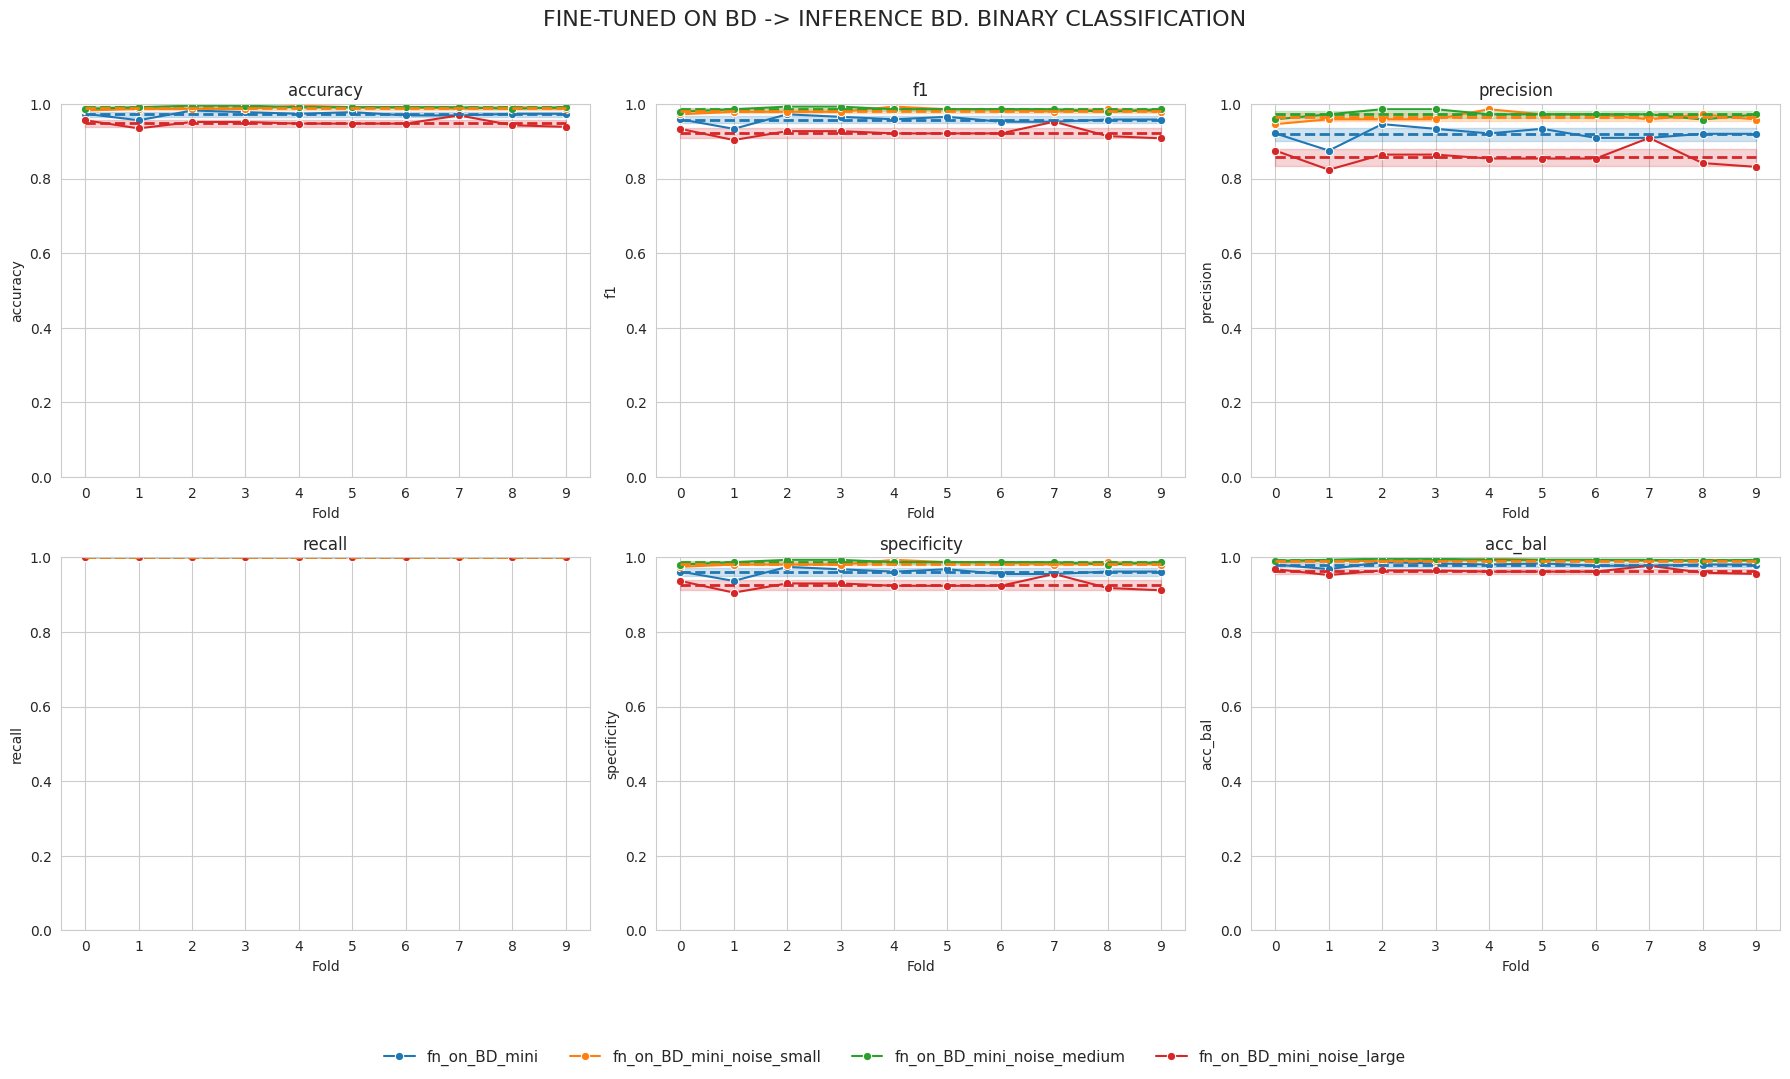

In [48]:
metrics_dict = {
    "fn_on_BD_mini": metrics_no_noise_01_BD_mini,
    "fn_on_BD_mini_noise_small": metrics_small_noise_01_BD_mini,
    "fn_on_BD_mini_noise_medium": metrics_medium_noise_01_BD_mini,
    "fn_on_BD_mini_noise_large": metrics_large_noise_01_BD_mini
}

metric_names = [
    "accuracy", "f1", "precision",
    "recall", "specificity", "acc_bal"
]

dfs = []
for setting, df in metrics_dict.items():
    tmp = df.copy()
    tmp["setting"] = setting
    tmp["fold_id"] = range(len(tmp))
    dfs.append(tmp)

df_all = pd.concat(dfs, ignore_index=True)

palette = sns.color_palette(n_colors=len(metrics_dict))
setting_colors = dict(zip(metrics_dict.keys(), palette))

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(18, 11))
axes = axes.flatten()

legend_handles, legend_labels = None, None

for i, metric in enumerate(metric_names):
    ax = axes[i]

    show_legend = (i == 0)

    sns.lineplot(
        data=df_all,
        x="fold_id",
        y=metric,
        hue="setting",
        marker="o",
        ax=ax,
        palette=setting_colors,
        legend=show_legend
    )

    if show_legend:
        legend_handles, legend_labels = ax.get_legend_handles_labels()
        ax.legend_.remove()

    for setting, df_setting in df_all.groupby("setting"):
        values = df_setting[metric].values
        mean_val = values.mean()
        std_val = values.std()
        folds = df_setting["fold_id"].values

        color = setting_colors[setting]

        ax.hlines(
            mean_val,
            xmin=folds.min(),
            xmax=folds.max(),
            linestyles="dashed",
            colors=color,
            linewidth=2
        )

        ax.fill_between(
            folds,
            mean_val - std_val,
            mean_val + std_val,
            color=color,
            alpha=0.2
        )

    ax.set_title(metric)
    ax.set_xlabel("Fold")
    ax.set_ylabel(metric)
    ax.set_xticks(np.arange(10))
    ax.set_ylim(0, 1)

fig.legend(
    legend_handles,
    legend_labels,
    loc="lower center",
    ncol=len(metrics_dict),
    frameon=False,
    fontsize=11
)

plt.suptitle(
    "FINE-TUNED ON BD -> INFERENCE BD. BINARY CLASSIFICATION",
    fontsize=16,
    y=0.97
)

plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()

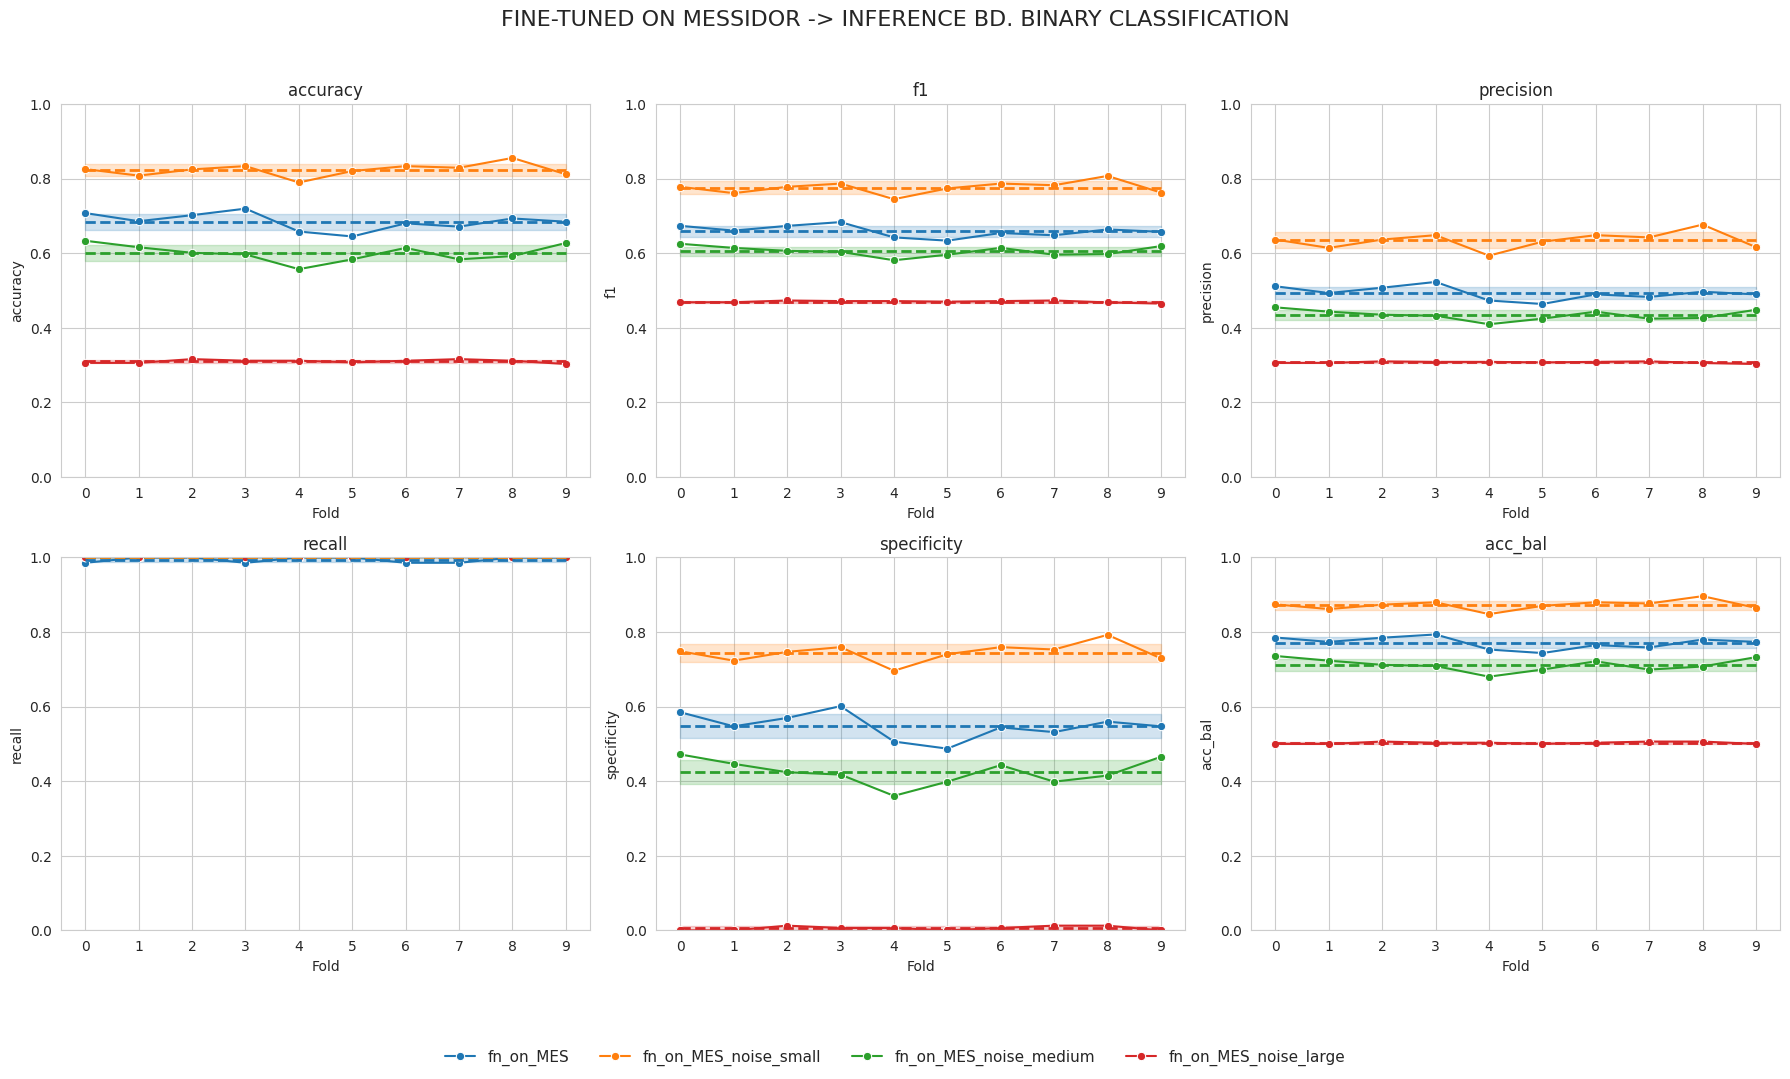

In [49]:
metrics_dict = {
    "fn_on_MES": metrics_no_noise_01_MES,
    "fn_on_MES_noise_small": metrics_small_noise_01_MES,
    "fn_on_MES_noise_medium": metrics_medium_noise_01_MES,
    "fn_on_MES_noise_large": metrics_large_noise_01_MES
}

metric_names = [
    "accuracy", "f1", "precision",
    "recall", "specificity", "acc_bal"
]

dfs = []
for setting, df in metrics_dict.items():
    tmp = df.copy()
    tmp["setting"] = setting
    tmp["fold_id"] = range(len(tmp))
    dfs.append(tmp)

df_all = pd.concat(dfs, ignore_index=True)

palette = sns.color_palette(n_colors=len(metrics_dict))
setting_colors = dict(zip(metrics_dict.keys(), palette))

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(18, 11))
axes = axes.flatten()

legend_handles, legend_labels = None, None

for i, metric in enumerate(metric_names):
    ax = axes[i]

    show_legend = (i == 0)

    sns.lineplot(
        data=df_all,
        x="fold_id",
        y=metric,
        hue="setting",
        marker="o",
        ax=ax,
        palette=setting_colors,
        legend=show_legend
    )

    if show_legend:
        legend_handles, legend_labels = ax.get_legend_handles_labels()
        ax.legend_.remove()

    for setting, df_setting in df_all.groupby("setting"):
        values = df_setting[metric].values
        mean_val = values.mean()
        std_val = values.std()
        folds = df_setting["fold_id"].values

        color = setting_colors[setting]

        ax.hlines(
            mean_val,
            xmin=folds.min(),
            xmax=folds.max(),
            linestyles="dashed",
            colors=color,
            linewidth=2
        )

        ax.fill_between(
            folds,
            mean_val - std_val,
            mean_val + std_val,
            color=color,
            alpha=0.2
        )

    ax.set_title(metric)
    ax.set_xlabel("Fold")
    ax.set_ylabel(metric)
    ax.set_xticks(np.arange(10))
    ax.set_ylim(0, 1)

fig.legend(
    legend_handles,
    legend_labels,
    loc="lower center",
    ncol=len(metrics_dict),
    frameon=False,
    fontsize=11
)

plt.suptitle(
    "FINE-TUNED ON MESSIDOR -> INFERENCE BD. BINARY CLASSIFICATION",
    fontsize=16,
    y=0.97
)

plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()

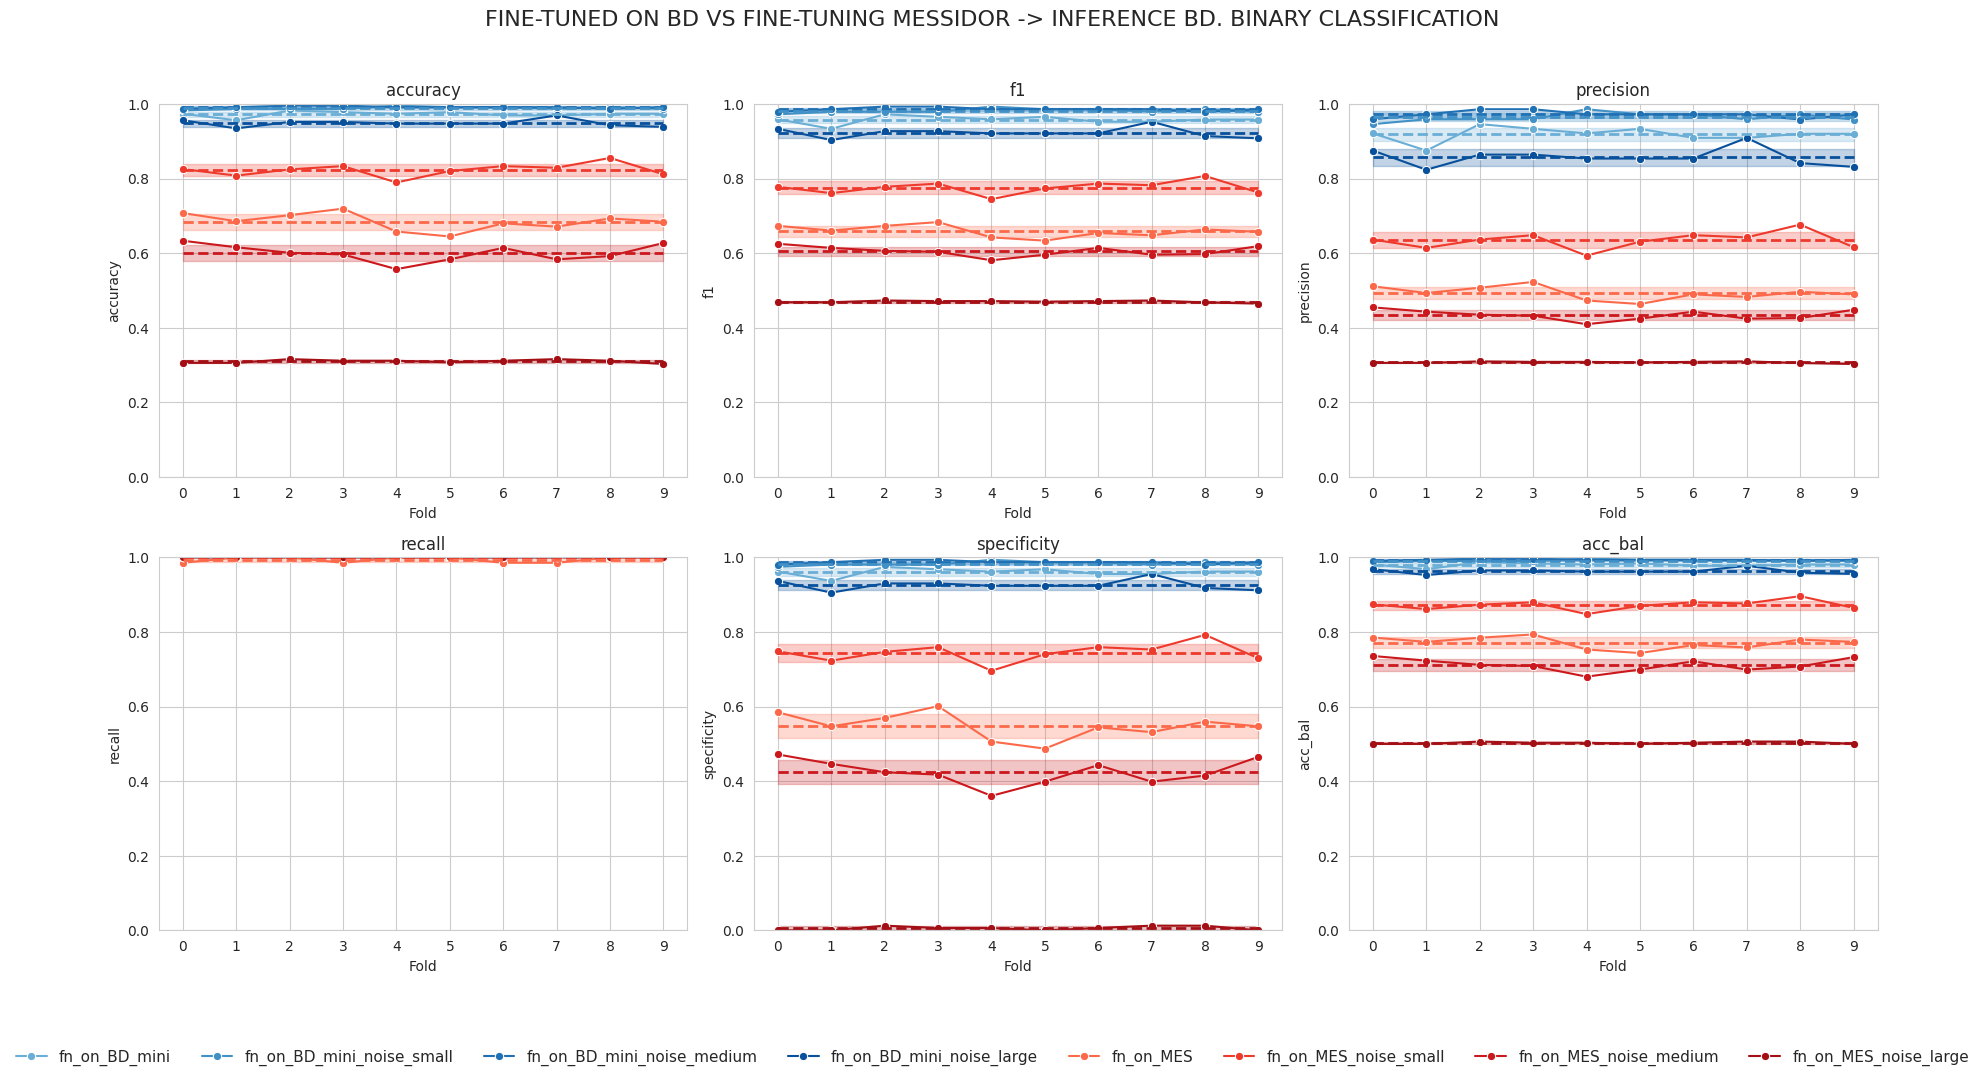

In [50]:
metrics_dict = {
    "fn_on_BD_mini": metrics_no_noise_01_BD_mini,
    "fn_on_BD_mini_noise_small": metrics_small_noise_01_BD_mini,
    "fn_on_BD_mini_noise_medium": metrics_medium_noise_01_BD_mini,
    "fn_on_BD_mini_noise_large": metrics_large_noise_01_BD_mini,
    "fn_on_MES": metrics_no_noise_01_MES,
    "fn_on_MES_noise_small": metrics_small_noise_01_MES,
    "fn_on_MES_noise_medium": metrics_medium_noise_01_MES,
    "fn_on_MES_noise_large": metrics_large_noise_01_MES
}

metric_names = [
    "accuracy", "f1", "precision",
    "recall", "specificity", "acc_bal"
]

dfs = []
for setting, df in metrics_dict.items():
    tmp = df.copy()
    tmp["setting"] = setting
    tmp["fold_id"] = range(len(tmp))
    dfs.append(tmp)

df_all = pd.concat(dfs, ignore_index=True)

bd_colors = sns.color_palette("Blues", 7) 
mes_colors = sns.color_palette("Reds", 7) 

palette = {
    "fn_on_BD_mini": bd_colors[3],
    "fn_on_BD_mini_noise_small": bd_colors[4],
    "fn_on_BD_mini_noise_medium": bd_colors[5],
    "fn_on_BD_mini_noise_large": bd_colors[6],

    "fn_on_MES": mes_colors[3],
    "fn_on_MES_noise_small": mes_colors[4],
    "fn_on_MES_noise_medium": mes_colors[5],
    "fn_on_MES_noise_large": mes_colors[6],
}

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(18, 11))
axes = axes.flatten()

legend_handles, legend_labels = None, None

for i, metric in enumerate(metric_names):
    ax = axes[i]
    show_legend = (i == 0)

    sns.lineplot(
        data=df_all,
        x="fold_id",
        y=metric,
        hue="setting",
        marker="o",
        ax=ax,
        palette=palette,
        legend=show_legend
    )

    if show_legend:
        legend_handles, legend_labels = ax.get_legend_handles_labels()
        ax.legend_.remove()

    for setting, df_setting in df_all.groupby("setting"):
        values = df_setting[metric].values
        mean_val = values.mean()
        std_val = values.std()
        folds = df_setting["fold_id"].values
        color = palette[setting]

        ax.hlines(
            mean_val,
            xmin=folds.min(),
            xmax=folds.max(),
            linestyles="dashed",
            colors=color,
            linewidth=2
        )

        ax.fill_between(
            folds,
            mean_val - std_val,
            mean_val + std_val,
            color=color,
            alpha=0.25
        )

    ax.set_title(metric)
    ax.set_xlabel("Fold")
    ax.set_ylabel(metric)
    ax.set_xticks(np.arange(10))
    ax.set_ylim(0, 1)

fig.legend(
    legend_handles,
    legend_labels,
    loc="lower center",
    ncol=len(metrics_dict),
    frameon=False,
    fontsize=11
)

plt.suptitle(
    "FINE-TUNED ON BD VS FINE-TUNING MESSIDOR -> INFERENCE BD. BINARY CLASSIFICATION",
    fontsize=16,
    y=0.97
)

plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()

### MULTI CLASSIFICATION

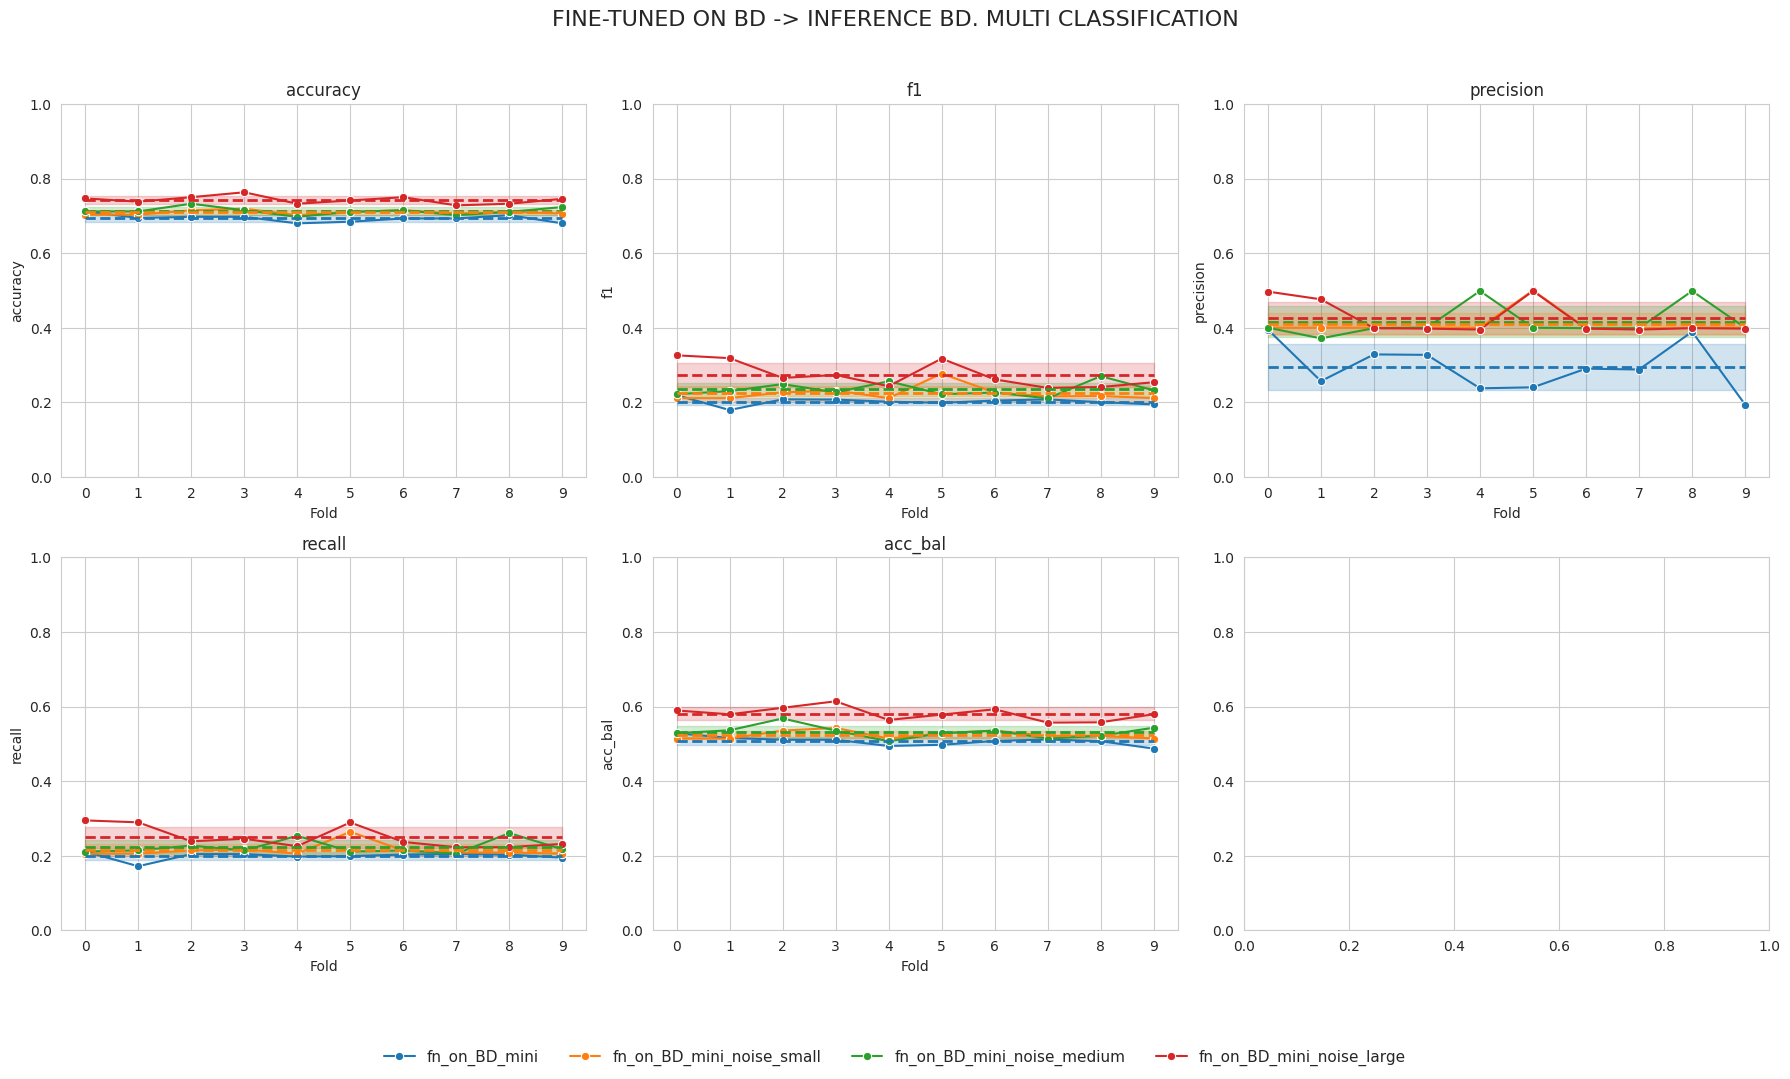

In [51]:
metrics_dict = {
    "fn_on_BD_mini": metrics_no_noise_04_BD_mini,
    "fn_on_BD_mini_noise_small": metrics_small_noise_04_BD_mini,
    "fn_on_BD_mini_noise_medium": metrics_medium_noise_04_BD_mini,
    "fn_on_BD_mini_noise_large": metrics_large_noise_04_BD_mini
}

metric_names = [
    "accuracy", "f1", "precision",
    "recall", "acc_bal"
]

dfs = []
for setting, df in metrics_dict.items():
    tmp = df.copy()
    tmp["setting"] = setting
    tmp["fold_id"] = range(len(tmp))
    dfs.append(tmp)

df_all = pd.concat(dfs, ignore_index=True)

palette = sns.color_palette(n_colors=len(metrics_dict))
setting_colors = dict(zip(metrics_dict.keys(), palette))

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(18, 11))
axes = axes.flatten()

legend_handles, legend_labels = None, None

for i, metric in enumerate(metric_names):
    ax = axes[i]

    show_legend = (i == 0)

    sns.lineplot(
        data=df_all,
        x="fold_id",
        y=metric,
        hue="setting",
        marker="o",
        ax=ax,
        palette=setting_colors,
        legend=show_legend
    )

    if show_legend:
        legend_handles, legend_labels = ax.get_legend_handles_labels()
        ax.legend_.remove()

    for setting, df_setting in df_all.groupby("setting"):
        values = df_setting[metric].values
        mean_val = values.mean()
        std_val = values.std()
        folds = df_setting["fold_id"].values

        color = setting_colors[setting]

        ax.hlines(
            mean_val,
            xmin=folds.min(),
            xmax=folds.max(),
            linestyles="dashed",
            colors=color,
            linewidth=2
        )

        ax.fill_between(
            folds,
            mean_val - std_val,
            mean_val + std_val,
            color=color,
            alpha=0.2
        )

    ax.set_title(metric)
    ax.set_xlabel("Fold")
    ax.set_ylabel(metric)
    ax.set_xticks(np.arange(10))
    ax.set_ylim(0, 1)

fig.legend(
    legend_handles,
    legend_labels,
    loc="lower center",
    ncol=len(metrics_dict),
    frameon=False,
    fontsize=11
)

plt.suptitle(
    "FINE-TUNED ON BD -> INFERENCE BD. MULTI CLASSIFICATION",
    fontsize=16,
    y=0.97
)

plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()

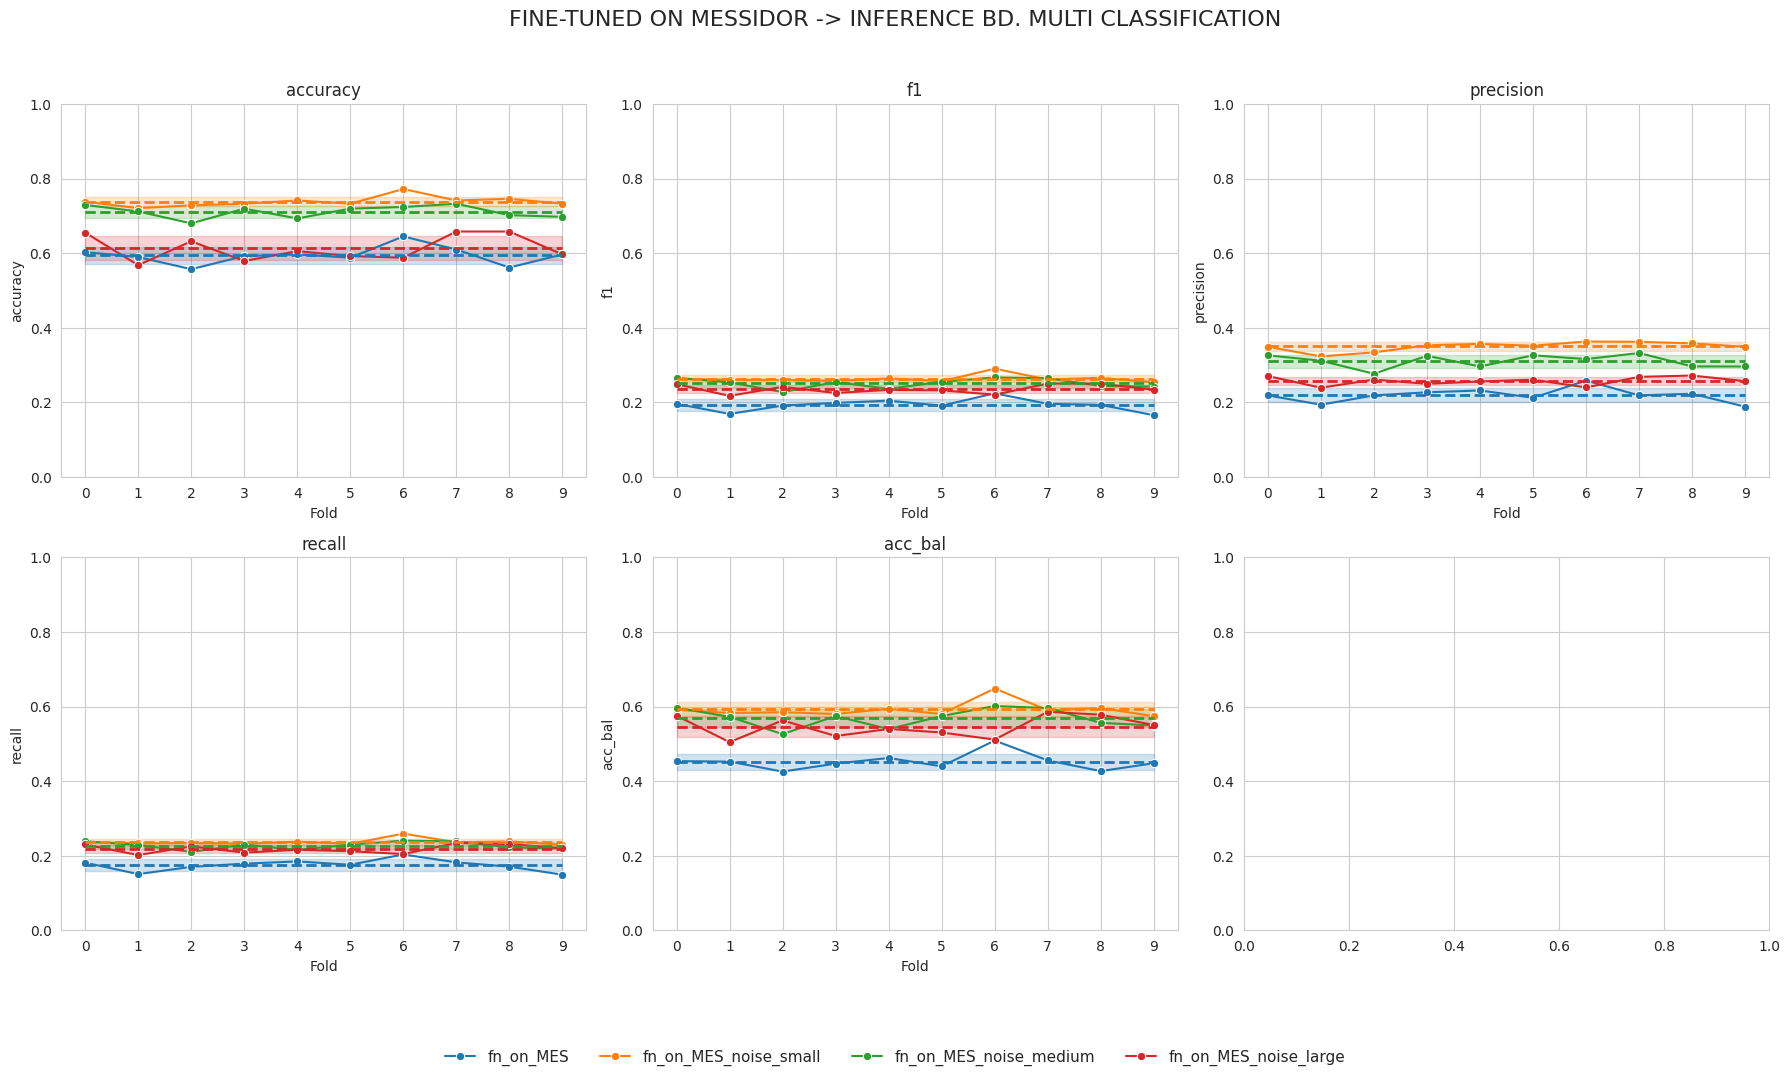

In [52]:
metrics_dict = {
    "fn_on_MES": metrics_no_noise_04_MES,
    "fn_on_MES_noise_small": metrics_small_noise_04_MES,
    "fn_on_MES_noise_medium": metrics_medium_noise_04_MES,
    "fn_on_MES_noise_large": metrics_large_noise_04_MES
}

metric_names = [
    "accuracy", "f1", "precision",
    "recall", "acc_bal"
]

dfs = []
for setting, df in metrics_dict.items():
    tmp = df.copy()
    tmp["setting"] = setting
    tmp["fold_id"] = range(len(tmp))
    dfs.append(tmp)

df_all = pd.concat(dfs, ignore_index=True)

palette = sns.color_palette(n_colors=len(metrics_dict))
setting_colors = dict(zip(metrics_dict.keys(), palette))

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(18, 11))
axes = axes.flatten()

legend_handles, legend_labels = None, None

for i, metric in enumerate(metric_names):
    ax = axes[i]

    show_legend = (i == 0)

    sns.lineplot(
        data=df_all,
        x="fold_id",
        y=metric,
        hue="setting",
        marker="o",
        ax=ax,
        palette=setting_colors,
        legend=show_legend
    )

    if show_legend:
        legend_handles, legend_labels = ax.get_legend_handles_labels()
        ax.legend_.remove()

    for setting, df_setting in df_all.groupby("setting"):
        values = df_setting[metric].values
        mean_val = values.mean()
        std_val = values.std()
        folds = df_setting["fold_id"].values

        color = setting_colors[setting]

        ax.hlines(
            mean_val,
            xmin=folds.min(),
            xmax=folds.max(),
            linestyles="dashed",
            colors=color,
            linewidth=2
        )

        ax.fill_between(
            folds,
            mean_val - std_val,
            mean_val + std_val,
            color=color,
            alpha=0.2
        )

    ax.set_title(metric)
    ax.set_xlabel("Fold")
    ax.set_ylabel(metric)
    ax.set_xticks(np.arange(10))
    ax.set_ylim(0, 1)

fig.legend(
    legend_handles,
    legend_labels,
    loc="lower center",
    ncol=len(metrics_dict),
    frameon=False,
    fontsize=11
)

plt.suptitle(
    "FINE-TUNED ON MESSIDOR -> INFERENCE BD. MULTI CLASSIFICATION",
    fontsize=16,
    y=0.97
)

plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()

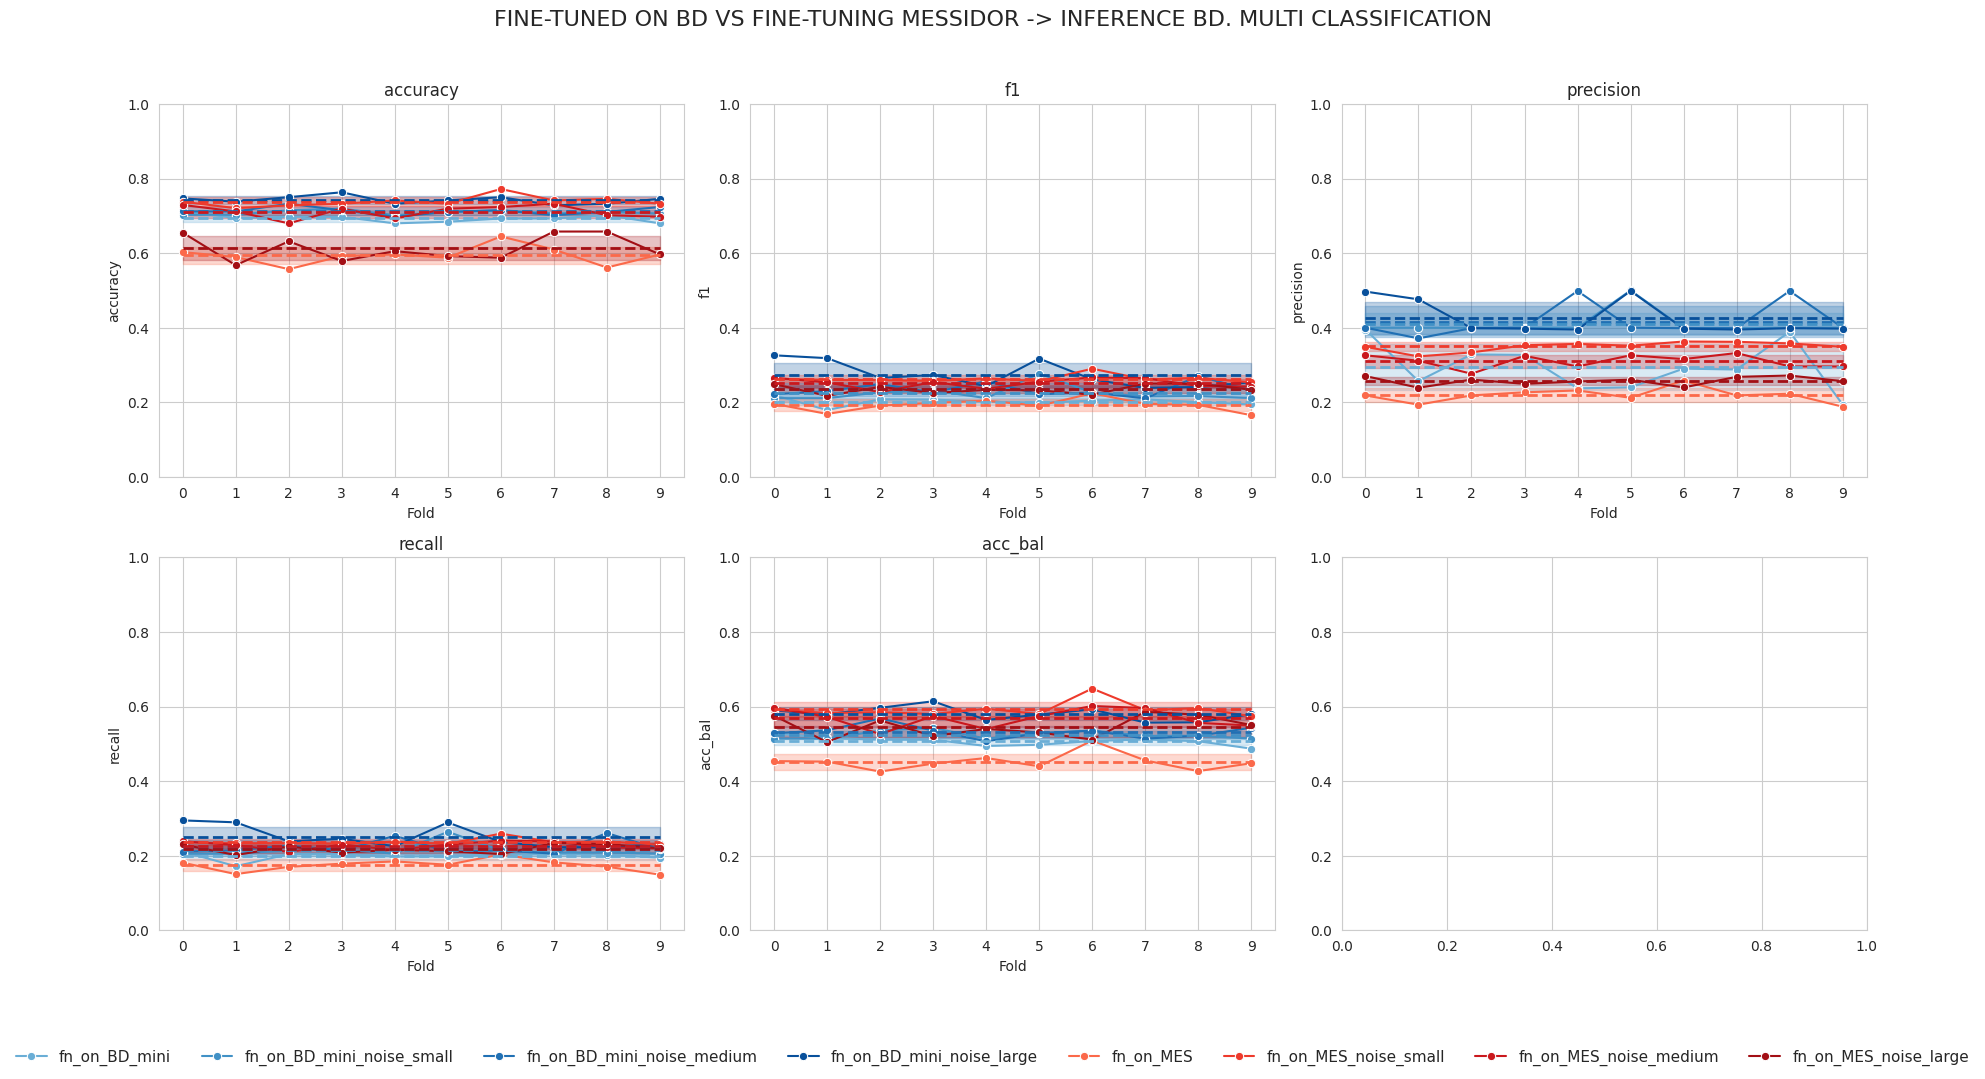

In [53]:
metrics_dict = {
    "fn_on_BD_mini": metrics_no_noise_04_BD_mini,
    "fn_on_BD_mini_noise_small": metrics_small_noise_04_BD_mini,
    "fn_on_BD_mini_noise_medium": metrics_medium_noise_04_BD_mini,
    "fn_on_BD_mini_noise_large": metrics_large_noise_04_BD_mini,
    "fn_on_MES": metrics_no_noise_04_MES,
    "fn_on_MES_noise_small": metrics_small_noise_04_MES,
    "fn_on_MES_noise_medium": metrics_medium_noise_04_MES,
    "fn_on_MES_noise_large": metrics_large_noise_04_MES
}

metric_names = [
    "accuracy", "f1", "precision",
    "recall", "acc_bal"
]

dfs = []
for setting, df in metrics_dict.items():
    tmp = df.copy()
    tmp["setting"] = setting
    tmp["fold_id"] = range(len(tmp))
    dfs.append(tmp)

df_all = pd.concat(dfs, ignore_index=True)

bd_colors = sns.color_palette("Blues", 7) 
mes_colors = sns.color_palette("Reds", 7) 

palette = {
    "fn_on_BD_mini": bd_colors[3],
    "fn_on_BD_mini_noise_small": bd_colors[4],
    "fn_on_BD_mini_noise_medium": bd_colors[5],
    "fn_on_BD_mini_noise_large": bd_colors[6],

    "fn_on_MES": mes_colors[3],
    "fn_on_MES_noise_small": mes_colors[4],
    "fn_on_MES_noise_medium": mes_colors[5],
    "fn_on_MES_noise_large": mes_colors[6],
}

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(18, 11))
axes = axes.flatten()

legend_handles, legend_labels = None, None

for i, metric in enumerate(metric_names):
    ax = axes[i]
    show_legend = (i == 0)

    sns.lineplot(
        data=df_all,
        x="fold_id",
        y=metric,
        hue="setting",
        marker="o",
        ax=ax,
        palette=palette,
        legend=show_legend
    )

    if show_legend:
        legend_handles, legend_labels = ax.get_legend_handles_labels()
        ax.legend_.remove()

    for setting, df_setting in df_all.groupby("setting"):
        values = df_setting[metric].values
        mean_val = values.mean()
        std_val = values.std()
        folds = df_setting["fold_id"].values
        color = palette[setting]

        ax.hlines(
            mean_val,
            xmin=folds.min(),
            xmax=folds.max(),
            linestyles="dashed",
            colors=color,
            linewidth=2
        )

        ax.fill_between(
            folds,
            mean_val - std_val,
            mean_val + std_val,
            color=color,
            alpha=0.25
        )

    ax.set_title(metric)
    ax.set_xlabel("Fold")
    ax.set_ylabel(metric)
    ax.set_xticks(np.arange(10))
    ax.set_ylim(0, 1)

fig.legend(
    legend_handles,
    legend_labels,
    loc="lower center",
    ncol=len(metrics_dict),
    frameon=False,
    fontsize=11
)

plt.suptitle(
    "FINE-TUNED ON BD VS FINE-TUNING MESSIDOR -> INFERENCE BD. MULTI CLASSIFICATION",
    fontsize=16,
    y=0.97
)

plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()